# Image Based Point Cloud Segmentation

Kefeng Huang timkhuang@icloud.com

## Dataset
Dataset configuration and initialization  

In [1]:
import pykitti

seq = '06'
kitti_path = r'../kitti-dataset'

kitti_dataset = pykitti.odometry(kitti_path, sequence=seq)

## Projection

### Project from Lidar to Image of the same frame

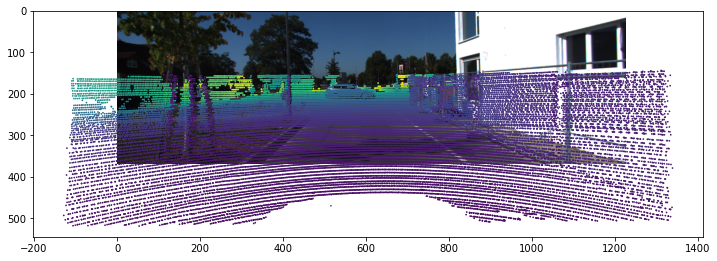

In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from converter import Converter


# Randomly choose a test image
sample_index = np.random.randint(len(kitti_dataset))
sample_velo = kitti_dataset.get_velo(sample_index)
sample_image = kitti_dataset.get_cam2(sample_index)

###################
# Projection Code #
convt = Converter(kitti_dataset.calib)
convt.set_fov()

in_view = convt.in_view_point(sample_velo)
image = convt.lidar_to_image(sample_velo)[in_view]
###################

# Code to Draw demo image
x = sample_velo[:, 0]
y = sample_velo[:, 1]
z = sample_velo[:, 2]
depth = np.sqrt(x**2 + y**2 + z**2)[in_view]
depth = depth / max(depth)

plt.rcParams['figure.figsize'] = [12, 10]
plt.imshow(sample_image)
plt.scatter(image[:, 0], image[:, 1], s=0.5, c=depth)
plt.show()


### Project from Lidar to Image of previous frames

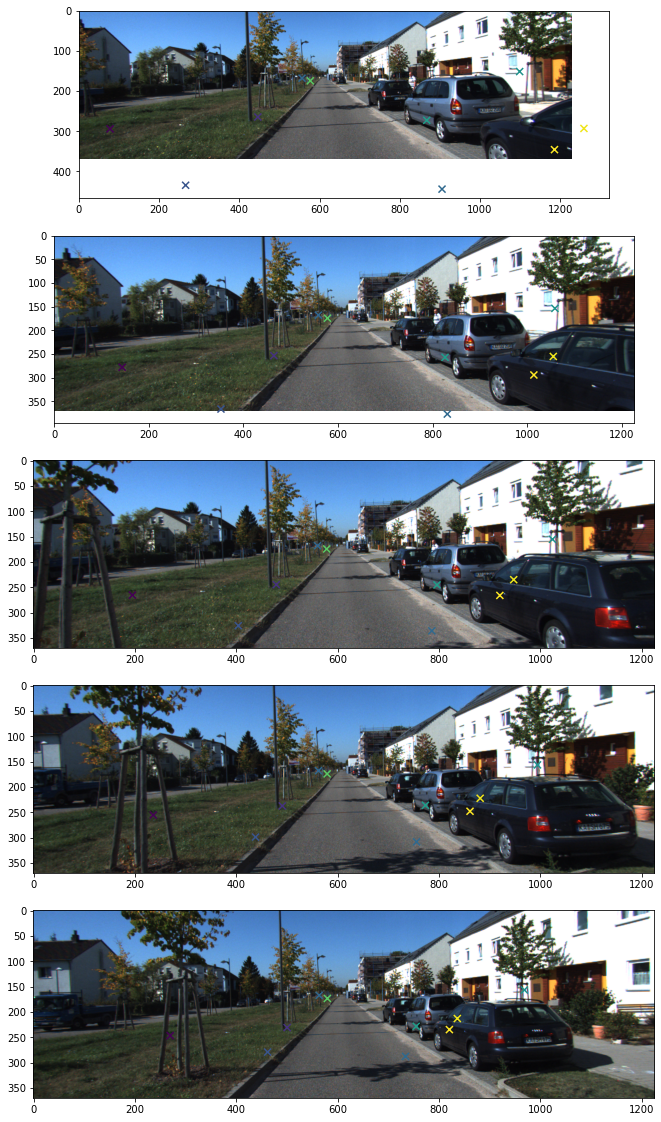

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from converter import Converter

# number of target images
num_prev = 4

# Randomly choose a test image
sample_index = np.random.randint(num_prev, len(kitti_dataset))
sample_velo = kitti_dataset.get_velo(sample_index)

###################
# Projection Code #
convt = Converter(kitti_dataset.calib)
convt.set_fov()

masks = np.zeros((num_prev + 1, len(sample_velo))).astype(bool)
result_images = np.zeros((num_prev + 1, len(sample_velo), 2))

for i in range(num_prev + 1):
    # current frame
    if i == 0:
        in_view = convt.in_view_point(sample_velo)
        image = convt.lidar_to_image(sample_velo)
    else:
        in_view, image = convt.lidar_to_target_image(
            sample_velo,
            kitti_dataset.poses[sample_index],
            kitti_dataset.poses[sample_index - i]
        )
    
    masks[i] = in_view
    result_images[i] = image
###################

# Code to Draw demo image
in_five_views = np.ones((len(sample_velo),)).astype(bool)
for i in range(num_prev + 1):
    in_five_views = in_five_views & masks[i]
result_images = result_images[:, in_five_views, :]

result_to_plot = result_images[:, np.random.randint(0, result_images.shape[1], 10), :]
result_color = np.random.uniform(size=10)

fig, axes = plt.subplots(num_prev + 1, figsize=(12, 20))
for i in range(num_prev + 1):
    axis = axes[i]
    axis.imshow(kitti_dataset.get_cam2(sample_index - i))
    axis.scatter(result_to_plot[i, :, 0], result_to_plot[i, :, 1], marker='x', s=50, c=result_color)
plt.show()
